In [28]:
import pandas as pd
import numpy as np
import backtest

In [29]:
np.random.seed(123)  # for reproducibility

In [30]:
# Mock datetime index (same as prices_df)
datetime_index = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')

# Mock asset symbols
assets = ['Asset_1', 'Asset_2', 'Asset_3', 'Asset_4', 'Asset_5']

# Generate random signal values for each asset and datetime
signal_data = np.random.rand(len(datetime_index) * len(assets)).reshape(len(datetime_index), len(assets))

# Create signals DataFrame with MultiIndex
index = pd.MultiIndex.from_product([datetime_index, assets], names=['datetime', 'asset'])
signals_df = pd.DataFrame(signal_data.flatten(), index=index, columns=['signal'])

print(signals_df.head())

                      signal
datetime   asset            
2024-01-01 Asset_1  0.696469
           Asset_2  0.286139
           Asset_3  0.226851
           Asset_4  0.551315
           Asset_5  0.719469


In [31]:
def generate_price_series(start_date, end_date, num_assets, mu, sigma, initial_price=100):
    # Generate dates
    dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Generate random shocks
    dt = 1  # Time step
    epsilon = np.random.normal(0, 1, size=(len(dates), num_assets))

    # Initialize prices DataFrame
    prices_df = pd.DataFrame(index=dates)

    # Calculate prices using Geometric Brownian Motion
    for i in range(num_assets):
        asset_name = f'Asset_{i+1}'
        prices = [initial_price]
        for t in range(len(prices_df.index) - 1):
            drift = mu * dt
            diffusion = sigma * np.sqrt(dt) * epsilon[t, i]
            price_today = prices[-1] * (1 + drift + diffusion)
            prices.append(price_today)
        prices_df[asset_name] = prices

    return prices_df

# Parameters
start_date = '2024-01-01'
end_date = '2024-12-31'
num_assets = 5
mu = 0.01  # Drift (expected return)
sigma = 0.2  # Volatility

# Generate price DataFrame
prices_df = generate_price_series(start_date, end_date, num_assets, mu, sigma)

# Print the price DataFrame
print(prices_df.head())


               Asset_1     Asset_2     Asset_3     Asset_4     Asset_5
2024-01-01  100.000000  100.000000  100.000000  100.000000  100.000000
2024-01-02   97.117114   96.975679  114.046106  102.744247  120.748569
2024-01-03  103.477291  112.706864  125.298588  117.031939  120.925998
2024-01-04  109.117378  107.724420  141.691891   86.696355  139.697009
2024-01-05  131.988934  124.782836  140.158850   96.323625  119.396835


cumulative_return = -0.98
annualised_return = -1.63
annualised_std = 1.55
sharpe = -1.05
max_drawdown = 0.99
calmar = -1.64


<Axes: title={'center': 'Example of backtest with randomly generated signals'}, xlabel='datetime'>

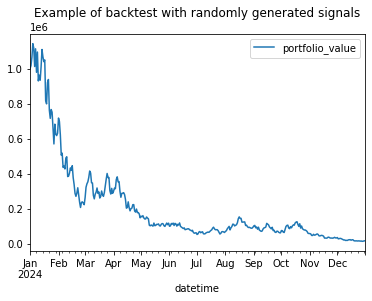

In [32]:
# Example usage:
# Assuming you have signals_df and prices_df ready
# signals_df should have a MultiIndex with 'datetime' and 'asset'
# prices_df should have a DateTimeIndex

# Set parameters
backtest_obj = backtest.VectorialBacktest(
    signals=signals_df, 
    prices=prices_df, 
    initial_cash=1000000, 
    commissions=5, 
    number_of_instruments_long_leg=2, 
    number_of_instruments_short_leg=2
)
# Run backtest
trades_df, equity_line_df, backtest_metrics = backtest_obj.do_backtest()

for key, value in backtest_metrics.items():
    print(f"{key} = {round(value,2)}") 

equity_line_df.plot(title="Example of backtest with randomly generated signals")


In [33]:
signals_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([
    ['2020-01-01', '2020-01-01', '2020-01-02', '2020-01-02',
     '2020-01-03','2020-01-03', '2020-01-04', '2020-01-04',
     '2020-01-05','2020-01-05'], [
         'A','B','A','B','A',
         'B','A','B','A','B'
     ]
], names=['datetime', 'asset']),
    data={
        'signal': [
            1,0,1,0,0,1,0,1,1,0
        ]})

prices_df = pd.DataFrame({
    'A': [100, 101, 100, 99, 100, 101],
    'B': [100, 95, 100, 105, 100, 90]
}, index=['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06'])



cumulative_return = 0.05
annualised_return = 2.77
annualised_std = 0.62
sharpe = 4.49
max_drawdown = 0.03
calmar = 88.45


<Axes: title={'center': 'Example of long short backtest without commissions'}>

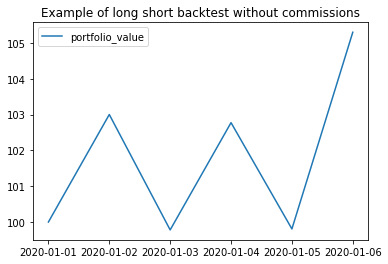

In [34]:
# No commissions
backtest_obj = backtest.VectorialBacktest(
    signals=signals_df, 
    prices=prices_df, 
    initial_cash=100, 
    commissions=0, 
    number_of_instruments_long_leg=1, 
    number_of_instruments_short_leg=1
)
# Run backtest
trades_df, equity_line_df, backtest_metrics = backtest_obj.do_backtest()

for key, value in backtest_metrics.items():
    print(f"{key} = {round(value,2)}") 

equity_line_df.plot(title="Example of long short backtest without commissions")

In [35]:
# checks
assert (trades_df['A'] == [0.5, 0.5, -0.5, -0.5, 0.5]).all()
assert (trades_df['B'] == -trades_df['A']).all()

assert (round(equity_line_df['portfolio_value'], 3) == [100, 103, 99.780, 102.773, 99.807, 105.296]).all()
assert round(backtest_metrics['max_drawdown'], 5) == round(0.03126628452, 5)

cumulative_return = 0.05
annualised_return = 2.63
annualised_std = 0.61
sharpe = 4.33
max_drawdown = 0.03
calmar = 82.41


<Axes: title={'center': 'Example of long short backtest with commissions'}>

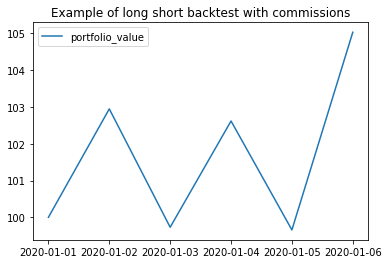

In [36]:
# with commissions
backtest_obj = backtest.VectorialBacktest(
    signals=signals_df, 
    prices=prices_df, 
    initial_cash=100, 
    commissions=5, 
    number_of_instruments_long_leg=1, 
    number_of_instruments_short_leg=1
)
# Run backtest
trades_df, equity_line_df, backtest_metrics = backtest_obj.do_backtest()

for key, value in backtest_metrics.items():
    print(f"{key} = {round(value,2)}") 

equity_line_df.plot(title="Example of long short backtest with commissions")


In [37]:
# checks
assert (trades_df['A'] == [0.5, 0.5, -0.5, -0.5, 0.5]).all()
assert (trades_df['B'] == -trades_df['A']).all()

assert (round(equity_line_df['portfolio_value'], 5) == [100.00000, 102.94850, 99.72968, 102.61885, 99.65727, 105.03328]).all()
assert round(backtest_metrics['max_drawdown'], 5) == round(0.03196968585, 5)

cumulative_return = 0.01
annualised_return = 0.5
annualised_std = 0.56
sharpe = 0.9
max_drawdown = 0.05
calmar = 10.49


<Axes: title={'center': 'Example of long only backtest with commissions'}>

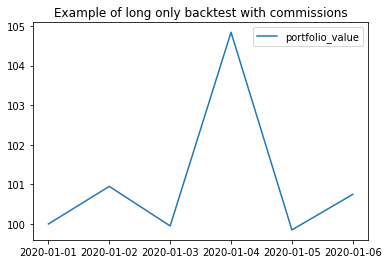

In [38]:
# long only
backtest_obj = backtest.VectorialBacktest(
    signals=signals_df, 
    prices=prices_df, 
    initial_cash=100, 
    commissions=5, 
    number_of_instruments_long_leg=1, 
    number_of_instruments_short_leg=0
)
# Run backtest
trades_df, equity_line_df, backtest_metrics = backtest_obj.do_backtest()

for key, value in backtest_metrics.items():
    print(f"{key} = {round(value,2)}") 

equity_line_df.plot(title="Example of long only backtest with commissions")

In [39]:
# checks
assert (trades_df['A'] == [1, 1, 0, 0, 1]).all()
assert (trades_df['B'] == 1 - trades_df['A']).all()

assert (round(equity_line_df['portfolio_value'], 5) == [100.00000, 100.94950, 99.95000, 104.84255, 99.85005, 100.74770]).all()
assert round(backtest_metrics['max_drawdown'], 5) == round(0.04761904762, 5)